## Imports

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as pplt

In [29]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [25]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDailyNsoDeathsByDeathDate"].to_numpy()
    print(dataDeath)
    time = np.linspace(offset,offset+len(data)-1, len(data))
    print(time)

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/1000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # create starting values based on data, does not inform inference but starts at a reasonable value
        # start beta conditional on start argument
        beta_start = (.034)
        
        # start gamma conditional on start argument
        gamma_start = (.050)
        
        # start rho conditional on start argument
        rho_start = (.034)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.034, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.020, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=500, tune=500, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

### Example

In [26]:
df = pd.read_csv("/Users/zenodeangeli/Documents/dissertation/raw_data/Covid_Data/cumDeathUK.csv")
mask = (df['date'] > "2020-04-10") & (df['date'] <= "2020-04-20")
df2 = df.loc[mask]
df2 = df2.iloc[::-1]
offset = 30
test_sample = sampleMCMC(offset,df2,67000000, 3)

[18483 19861 21093 22347 23623 24945 26217 27406 28528 29688]
[30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


/var/folders/m1/788d4jvn7wz8lm3qp0_815hc0000gn/T/ipykernel_14634/1556642692.py:52: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  model_trace = pm.sample(draws=500, tune=500, step=step, start=start, chains=5, cores=16)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 500 tune and 500 draw iterations (2_50

In [30]:
these_results = (pm.summary(test_sample, var_names=['i0','beta','gamma','rho','sigma'], round_to=5))
these_results

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
i0,66982.18280,257.26803,66523.00000,67489.00000,18.33233,12.98216,197.31453,405.16581,1.02377
beta,0.16020,0.02810,0.11306,0.21158,0.00194,0.00141,266.21004,206.21258,1.01939
gamma,0.12257,0.02822,0.07506,0.17332,0.00193,0.00141,269.85428,216.59053,1.01940
rho,0.04349,0.00869,0.02718,0.06052,0.00053,0.00038,264.42212,205.91729,1.02023
sigma,281.49400,77.06971,173.49153,420.17297,3.11965,2.29058,771.64059,665.01525,1.00554


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


numpy.ndarray

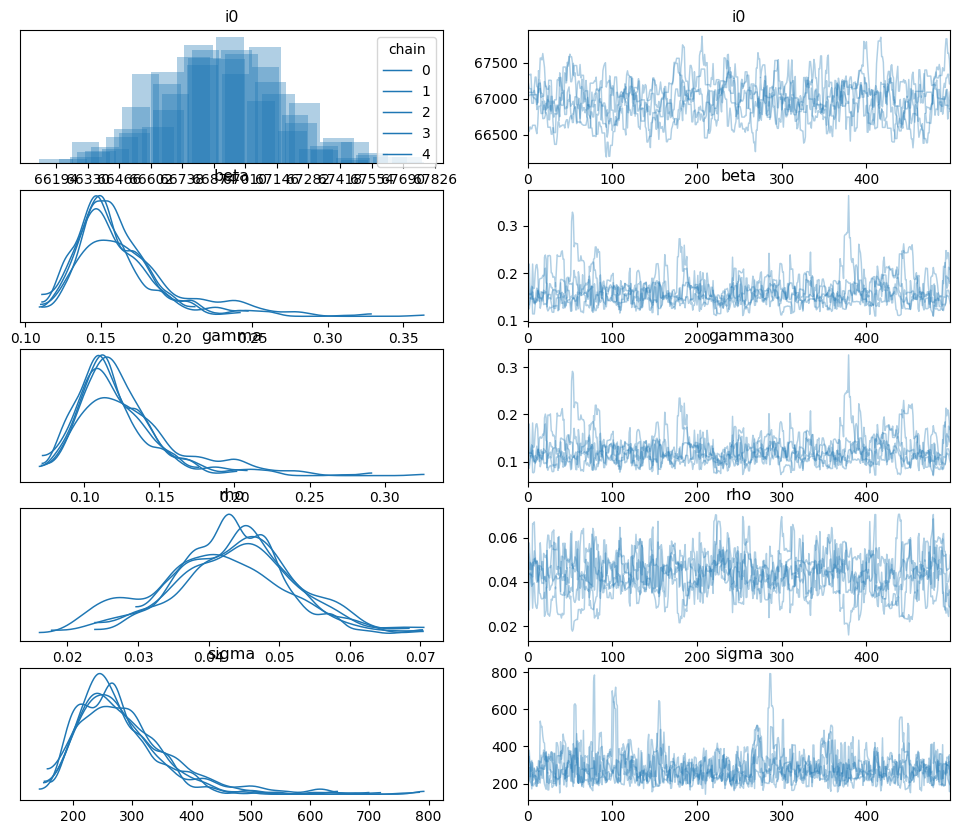

In [31]:
plot = pm.plot_trace(test_sample, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))
type(plot)

## Preparing 

In [ ]:
# file names, dates and offsets for first quarantine
quarantine_one_filename = []
quarantine_one_offsets = []
quarantine_one_dates = []
quarantine_one_population = []

# file names, dates and and offsets for second quarantine
quarantine_two_filename = []
quarantine_two_offsets = []
quarantine_two_dates = []
quarantine_two_population = []

In [ ]:
# Prepare all the datasets
quarantine_one_df = []
for filename in quarantine_one_filename:
    quarantine_one_df.append(pd.read_csv(filename))

# Prepare all the datasets
quarantine_two_df = []
for filename in quarantine_two_filename:
    quarantine_two_df.append(pd.read_csv(filename))

## Running Analysis

In [ ]:
# Begin loop to run all the analysis on the first quarantine
quarantine_one_results = []
for index, dataframe in enumerate(quarantine_one_df):
    try:
        quarantine_one_results.append(sampleMCMC(quarantine_one_offsets[index],dataframe,quarantine_one_population[index], 3))

    except:
        next

# Begin loop to run all the analysis on the second quarantine
quarantine_two_results = []
for index, dataframe in enumerate(quarantine_two_df):
    try:
        quarantine_two_results.append(sampleMCMC(quarantine_two_offsets[index],dataframe,quarantine_two_population[index], 3))
    except:
        next


## Plotting Results

In [ ]:
# Plotting all results of the first set of quarantines
for result in quarantine_one_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))
    
# Plotting all results of the second set of quarantines
for result in quarantine_two_results:
    plot = pm.plot_trace(result, var_names=('i0','beta','gamma','rho','sigma'),compact=True, legend=True, chain_prop=("ls", "-"))

## Data Visualization

In [35]:
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

shapefile = "/Users/zenodeangeli/Desktop/IndividualProject/data/ne_110m_admin_0_countries.shp"
geo_df = gpd.read_file(shapefile)

/Users/zenodeangeli/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


(30.0, 70.0)

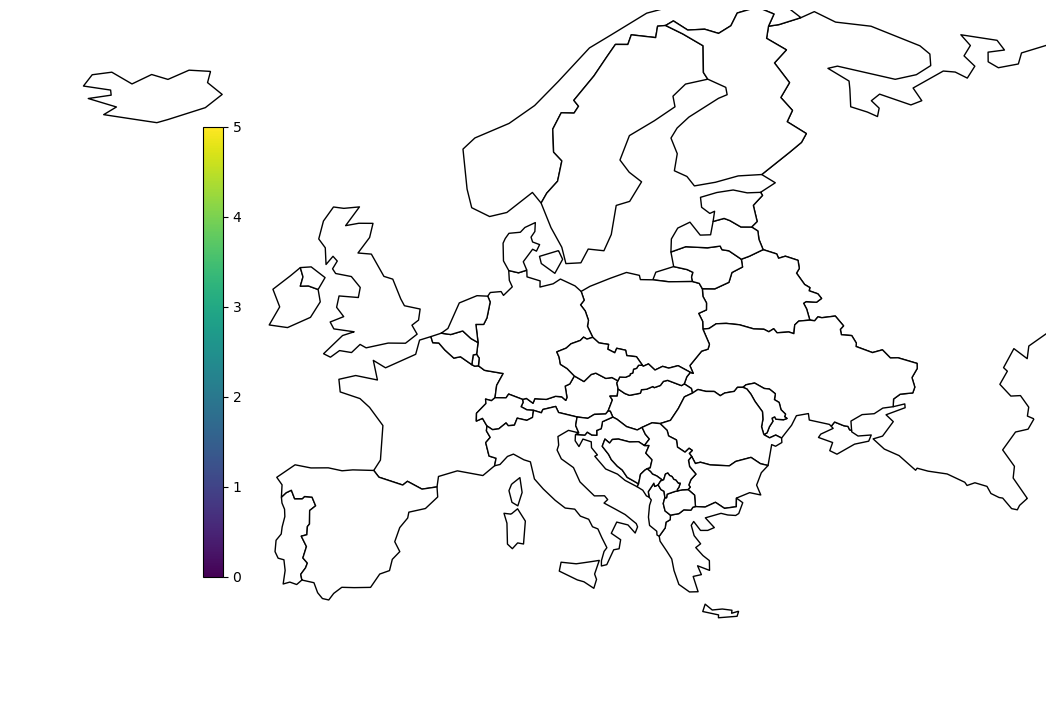

In [58]:
# General Information
country_list = ["Italy", "United Kindgom", "Spain", "Switzerland", "France", "Germany"]
vmin = 0
vmax = 5
col = "Example"
fig, ax = plt.subplots(1, figsize=(20, 9))
ax.axis('off')
africa_map_df = geo_df[geo_df['NAME'].isin(country_list)]

# Plotting the desired continent
geo_df[(geo_df["CONTINENT"] == "Europe")].plot(column=col, ax=ax, color='white', edgecolor='black')

# Adding Cmap to 
cmap = 'viridis'
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
cbaxes = fig.add_axes([0.35, 0.25, 0.01, 0.5])
cbar = fig.colorbar(sm, cax=cbaxes)

# Setting Axis limits
ax.set_xlim(-30, 50)
ax.set_ylim(30, 70)